### Predict Type 2 diabetes with EHR data

This project is based on a hackathon I did in graduate school. I applied same methods as in the breast cancer project.   
Diabetes is prevalent in the US with more than 450 million patients with various sever complications and is one of the major challenges in health care. A timely diagnosis and preventative treatment could reduce medical cost and increase life quality of patients. With advancement on portable medical devices, individuals can easily monitor their glucose level, body weight and fat ratio data continuously and easily. Further with a predictive model, they can detect abnormal condition before they go to hospital.  
To improve our understanding of diabetes and help people manage the disease, I developed a predictive model on diabetes on MIMIC III and PIMA medical data using NLP and other integrated machine leaning models. I explored features of glucose level, BMI (body mass index), age as well as free-text medical notes. I started with single classifier, improved by GridSearchCV and model ensemble, finally achieved an accuracy of 88%. I consider our model could potentially complement some existing preventive models for individuals to monitor their risk of diabetes and support medical diagnosis.  
Data:  
Two independent datasets were used in this study to increase data size to 268 case and 1448 control samples.   
[MIMIC III](https://physionet.org/content/mimiciii-demo/1.4/)  
[PIMA](https://en.wikipedia.org/wiki/RNA-Seq) Pima Indians Diabetes Database 

In [16]:
import pandas as pd
import numpy as np
from time import process_time
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import validation_curve, GridSearchCV, learning_curve
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn import tree
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.model_selection import cross_val_score

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore") 

### data processing

In [59]:
df = pd.read_csv('../data/diabetes.csv', index_col=None, )

case = df[df['Outcome']==1]
control = df[df['Outcome']==0]

In [3]:
case[['BMI','Age','Glucose']].describe()

,BMI,Age,Glucose
count,268.000000,268.000000,268.000000
mean,35.142537,37.067164,141.257463
std,7.262967,10.968254,31.939622
min,0.000000,21.000000,0.000000
25%,30.800000,28.000000,119.000000
50%,34.250000,36.000000,140.000000
75%,38.775000,44.000000,167.000000
max,67.100000,70.000000,199.000000


In [6]:
control[['BMI','Age','Glucose']].describe()

,BMI,Age,Glucose
count,500.000000,500.000000,500.0000
mean,30.304200,31.190000,109.9800
std,7.689855,11.667655,26.1412
min,0.000000,21.000000,0.0000
25%,25.400000,23.000000,93.0000
50%,30.050000,27.000000,107.0000
75%,35.300000,37.000000,125.0000
max,57.300000,81.000000,197.0000


In [5]:
mimc = pd.read_csv('../data/df_control.csv', index_col=None)
mimc = mimc[['bmi', 'age','Numeric_Result']]
mimc.columns = [['BMI','Age','Glucose']]
mimc['Outcome'] = 0
tmp = df[['BMI','Age','Glucose','Outcome']]
tmp['Glucose'] = tmp['Glucose'].astype(float)
df2 = pd.DataFrame(np.concatenate((tmp.values, mimc.values), axis=0 ))
df2.columns = ['BMI','Age','Glucose','Outcome']
df2['Outcome'] = df2['Outcome'].astype(int)
df2.to_csv('df_merged.csv', index=False)

In [86]:
df2.describe()

,BMI,Age,Glucose,Outcome
count,1716.000000,1716.000000,1716.000000,1716.000000
mean,27.646911,39.975524,100.971445,0.156177
std,8.072475,12.831607,28.155541,0.363129
min,0.000000,12.000000,0.000000,0.000000
25%,21.300000,29.000000,80.000000,0.000000
50%,27.200000,39.000000,90.000000,0.000000
75%,33.300000,50.000000,112.000000,0.000000
max,67.100000,81.000000,199.000000,1.000000


In [8]:
df2.shape

(1716, 4)

In [28]:
# pima+mimc
y = df2['Outcome'].values
X = df2.drop(['Outcome'], axis=1)
X = preprocessing.scale(X)
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size = 0.2, random_state=42)
X_train, y_train, X_test, y_test= train_x, train_y, test_x, test_y

### decision tree (DT), using max_depth and ccp_alpha for pruning
I used DecisionTreeClassifier from the sklearn package. Pre-pruning (early stop tree) and post-pruning (after trained) help to reduce overfitting in decision tree. Tuning hyper-parameter of max_depth min_samples_leaf, and min_samples_split (pre-pruning) and CCP cost-complexity-pruning (post-pruning) are common ways. I plotted test_score and train_score with validation_curve to understand performance of max_depth and ccp_alpha values, found an optimal parameters with GridSearchCV and evaluated time performance. Cross validation help to flag overfitting and tell the model will generalize to a new dataset. I used 3 fold cv, which is a commonly used number. I used learning_curve to determines cross-validated training and test scores for di
fferent training set sizes.

For max_depth, once score reaches 1.00 the model starts to overfit along with increased max_depth values.
For ccp_alpha, more tree is pruned as ccp value increase so score decreased.
GridSearchCV yield the best parameter as {'ccp_alpha': 0.0, 'max_depth': 4}, which gives accuracy_score of 0.8808139534883721.
There is stil a big gap between training and cv scores on learning curve, which suggests high variance in the model. It might be reduced with more data and with model of less features/less complexity. 

In [22]:
def get_clf_dt(_range, param_name, title):
    clf_dt = DecisionTreeClassifier(random_state=42)

    train_scores, test_scores = validation_curve(clf_dt, train_x, train_y, param_range=_range, cv=3, param_name=param_name)
    plt.figure()
    plt.plot(_range, np.mean(train_scores, axis=1), label='train_score')
    plt.plot(_range, np.mean(test_scores, axis=1), label='cv_score')
    plt.title(title)
    plt.xlabel(title)
    plt.ylabel("score")
    # plt.xticks(_range)
    plt.legend()
    plt.grid()

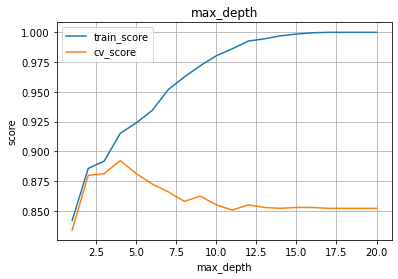

In [23]:
_range=[i for i in range(1,21)]
get_clf_dt(_range, param_name='max_depth', title='max_depth')

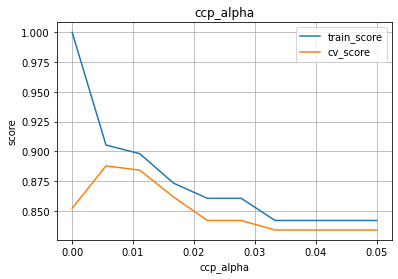

In [24]:
_range = np.linspace(0,0.05,10)
get_clf_dt(_range, param_name='ccp_alpha', title='ccp_alpha')

In [29]:
param_grid = {'max_depth': [i for i in range(1,21)], 'ccp_alpha': np.linspace(0,0.05,10)}
clf_dt = DecisionTreeClassifier(random_state=42)
gridsearch = GridSearchCV(clf_dt, param_grid=param_grid, cv=3)
gridsearch.fit(train_x, train_y)
print(gridsearch.best_params_)

time_start = process_time()
clf_dt = DecisionTreeClassifier(random_state=42, max_depth=gridsearch.best_params_['max_depth'], ccp_alpha=gridsearch.best_params_['ccp_alpha'])
clf_dt = clf_dt.fit(train_x, train_y)
clf_dt.fit(train_x, train_y)
predict_y = clf_dt.predict(test_x)
time_end = process_time()
print(accuracy_score(test_y, predict_y))
print(time_end-time_start)

{'ccp_alpha': 0.0, 'max_depth': 4}
0.8808139534883721
0.0028959999999997876


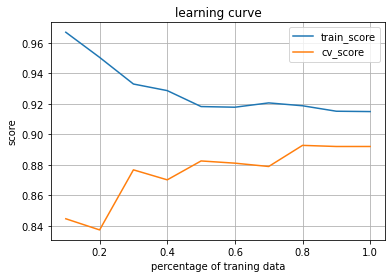

In [30]:
_range = np.linspace(0.1, 1.0, 10)
x, train_scores, test_scores = learning_curve(clf_dt, train_x, train_y, train_sizes=_range, cv=3)

plt.figure()
plt.plot(_range, np.mean(train_scores, axis=1), label='train_score')
plt.plot(_range, np.mean(test_scores, axis=1), label='cv_score')
plt.title("learning curve")
plt.xlabel("percentage of traning data")
plt.ylabel("score")
plt.legend()
plt.grid()

### neural network (NN)
I used MLPClassifier. Some commonly used hypter-parameters are hidden_layer_sizes, activation, and alpha. I plotted the hyper-parameter hidden_layer_sizes and alpha (Strength of the L2 regularization term) with validation_curve to understand the performance.
GridSearchCV yield the best parameter as {'alpha': 0.001, 'hidden_layer_sizes': (7, 7)} with accuracy 0.9069767441860465, which is good.
It takes longer time but still reasonable for NN, which tend to be long.
Performance of train and cv scores are close and both high, which suggest NN might be a good model with less bias and variance for this dataset.
I used loss curve to see how training error decrease with epochs. Training loss decreased as epoch increase and converged, suggesting the model perform well.

In [38]:
def get_clf_nn(_range, plot_range, param_name, title):
    clf_nn = MLPClassifier(random_state=42)
    train_scores, test_scores = validation_curve(clf_nn, train_x, train_y, param_range=_range, cv=3, param_name=param_name)
    plt.figure()
    plt.plot(plot_range, np.mean(train_scores, axis=1), label='train_score')
    plt.plot(plot_range, np.mean(test_scores, axis=1), label='cv_score')
    plt.title(title)
    plt.xlabel(title)
    plt.ylabel("score")
    # plt.xticks(_range)
    plt.legend()
    plt.grid()

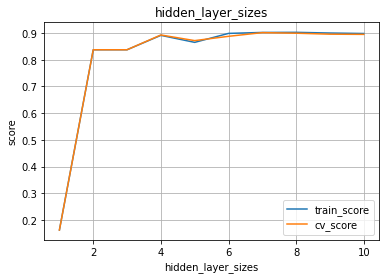

In [37]:
get_clf_nn(_range = [(i,i) for i in range(1,11)], plot_range=[i for i in range(1,11)], param_name='hidden_layer_sizes', title='hidden_layer_sizes')

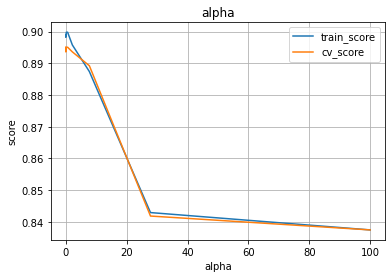

In [39]:
_range= np.logspace(-3,2,10)
get_clf_nn(_range = _range, plot_range=_range, param_name='alpha', title='alpha')

In [41]:
param_grid = {'hidden_layer_sizes': [(i,i) for i in range(1,11)], 'alpha':  np.logspace(-3,2,10)}
clf_nn = MLPClassifier(random_state=42)
gridsearch = GridSearchCV(clf_nn, param_grid=param_grid, cv=3)
gridsearch.fit(train_x, train_y)
print(gridsearch.best_params_)
time_start = process_time()
clf_nn = MLPClassifier(random_state=42, hidden_layer_sizes=gridsearch.best_params_['hidden_layer_sizes'], alpha=gridsearch.best_params_['alpha'])
clf_dt = clf_nn.fit(train_x, train_y)
clf_dt.fit(train_x, train_y)
predict_y = clf_nn.predict(test_x)
time_end = process_time()
print(accuracy_score(test_y, predict_y))
print(time_end-time_start)

{'alpha': 0.001, 'hidden_layer_sizes': (7, 7)}
0.9069767441860465
1.2619889999999998


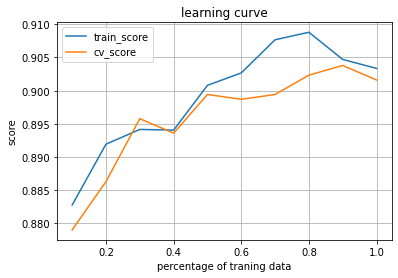

In [42]:
_range = np.linspace(0.1, 1.0, 10)
x, train_scores, test_scores = learning_curve(clf_nn, train_x, train_y, train_sizes=_range, cv=3)

plt.figure()
plt.plot(_range, np.mean(train_scores, axis=1), label='train_score')
plt.plot(_range, np.mean(test_scores, axis=1), label='cv_score')
plt.title("learning curve")
plt.xlabel("percentage of traning data")
plt.ylabel("score")
plt.legend()
plt.grid()

### Boosting
I used ensembl model of AdaBoostClassifier for boosting with varied number of weak leanrs (n_estimators) and learning_rate. GridSearchCV yield {'learning_rate': 0.31622776601683794, 'n_estimators': 1201} as the best parameter, with accuracy 0.8808139534883721. This model take longer time than other models, which is expected for AdaBoost. There is big gap on performance between train and cv, suggesting the model is not a good fit for this data.

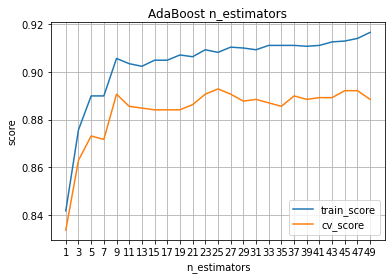

In [44]:
max_depth = 1
clf_adb = AdaBoostClassifier(random_state=42, base_estimator=tree.DecisionTreeClassifier(max_depth=max_depth))
# n_estimators default 50
_range = np.arange(1,50,2)
train_scores, test_scores = validation_curve(clf_adb, train_x, train_y, param_range=_range, cv=3, param_name='n_estimators')
plt.figure()
plt.plot(_range, np.mean(train_scores, axis=1), label='train_score')
plt.plot(_range, np.mean(test_scores, axis=1), label='cv_score')
plt.title("AdaBoost n_estimators")
plt.xlabel("n_estimators")
plt.ylabel("score")
plt.xticks(_range)
plt.legend()
plt.grid()

In [45]:
max_depth = 1
clf_adb = AdaBoostClassifier(random_state=42, base_estimator=tree.DecisionTreeClassifier(max_depth=max_depth))
param_grid = {'n_estimators': np.arange(1,2000,400), 'learning_rate': np.logspace(-2,1,5)}
gridsearch = GridSearchCV(clf_adb, param_grid=param_grid, cv=5)
gridsearch.fit(train_x, train_y)
print(gridsearch.best_params_)

time_start = process_time()
clf_adb = AdaBoostClassifier(random_state=42, learning_rate=gridsearch.best_params_['learning_rate'], n_estimators=gridsearch.best_params_['n_estimators'], base_estimator=tree.DecisionTreeClassifier(max_depth=max_depth))
clf_adb.fit(train_x, train_y)
predict_y = clf_adb.predict(test_x)
time_end = process_time()
print(accuracy_score(test_y, predict_y))
print(time_end-time_start)

{'learning_rate': 0.31622776601683794, 'n_estimators': 1201}
0.8808139534883721
2.1961220000000026


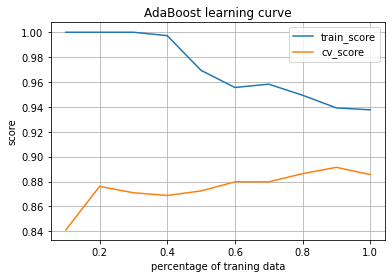

In [46]:
_range = np.linspace(0.1, 1.0, 10)
x, train_scores, test_scores = learning_curve(clf_adb, train_x, train_y, train_sizes=_range, cv=3)
plt.figure()
plt.plot(_range, np.mean(train_scores, axis=1), label='train_score')
plt.plot(_range, np.mean(test_scores, axis=1), label='cv_score')
plt.title("AdaBoost learning curve")
plt.xlabel("percentage of traning data")
plt.ylabel("score")
plt.legend()
plt.grid()

### Support Vector Machines (SVM)
I used SVC and LinearSVC, with varied hypter-parameter C (regularization) and different kernel types. GridSearchCV yield {'C': 0.0774263682681127, 'kernel': 'rbf'} as the best parameter, with accuracy 0.9011627906976745, which is not bad. SVM is very fast and outperform LinearSVC. Train and cv showed small gap and converged with high score on learning curve, suggesting SVM is a good model for this data.

In [47]:
def set_svm(_range, kernel, probability):
    clf_svm = svm.SVC(probability=probability, random_state=42, kernel=kernel)
    train_scores, test_scores = validation_curve(clf_svm, train_x, train_y, param_range=_range, cv=3, param_name='C')
    plt.figure()
    plt.semilogx(_range, np.mean(train_scores, axis=1), label='train_score')
    plt.semilogx(_range, np.mean(test_scores, axis=1), label='cv_score')
    plt.title("SVM C regularization")
    plt.xlabel("C regularization")
    plt.ylabel("score")
    plt.xticks(_range)
    plt.legend()
    plt.grid()

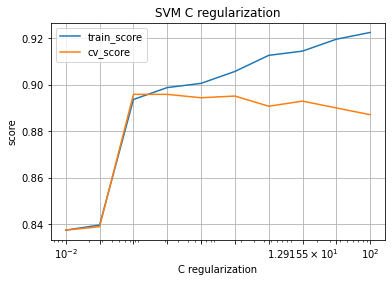

In [48]:
_range = np.logspace(-2,2,10)
set_svm(_range=_range, kernel='rbf', probability=True)

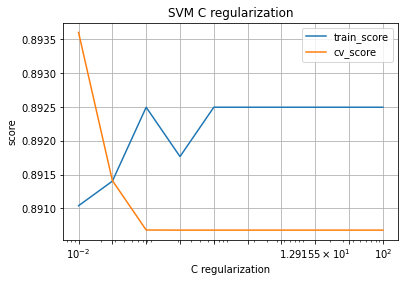

In [49]:
set_svm(_range=_range, kernel='linear', probability=True)

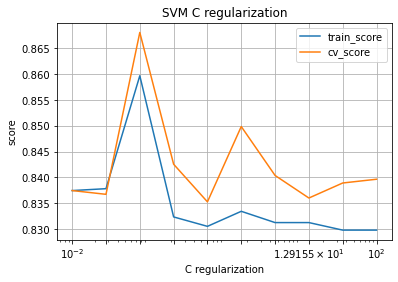

In [50]:
set_svm(_range=_range, kernel='sigmoid', probability=False)

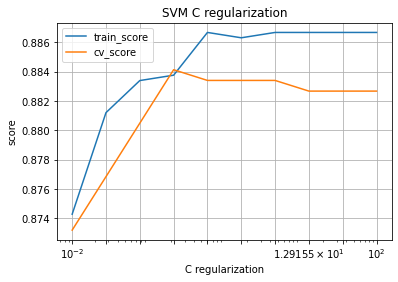

In [51]:
set_svm(_range=_range, kernel='poly', probability=False)

In [52]:
clf_svm = svm.SVC(random_state=42)
param_grid = {'C': np.logspace(-2,2,10), 'kernel': ['linear', 'rbf', 'sigmoid', 'poly']}
gridsearch_svm = GridSearchCV(clf_svm, param_grid=param_grid, cv=3)
gridsearch_svm.fit(train_x, train_y)
print(gridsearch_svm.best_params_)

time_start = process_time()
clf_svm = svm.SVC(random_state=42, kernel=gridsearch_svm.best_params_['kernel'], C=gridsearch_svm.best_params_['C'])
clf_svm.fit(train_x, train_y)
predict_y = clf_svm.predict(test_x)
print(accuracy_score(test_y, predict_y))
time_end = process_time()
print(time_end-time_start)

{'C': 0.0774263682681127, 'kernel': 'rbf'}
0.9011627906976745
0.0434139999999843


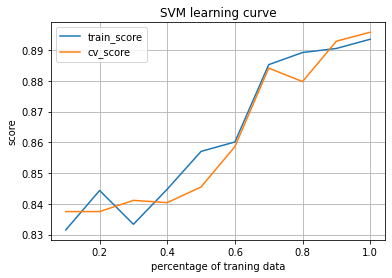

In [53]:
_range = np.linspace(0.1, 1.0, 10)
x, train_scores, test_scores = learning_curve(clf_svm, train_x, train_y, train_sizes=_range, cv=3)
plt.figure()
plt.plot(_range, np.mean(train_scores, axis=1), label='train_score')
plt.plot(_range, np.mean(test_scores, axis=1), label='cv_score')
plt.title("SVM learning curve")
plt.xlabel("percentage of traning data")
plt.ylabel("score")
plt.legend()
plt.grid()

### k-nearest neighbors
I used KNeighborsClassifier with various n_neighbors (Number of neighbors to use). As kNN scans the training data and calculate distance between query point and current point, it is very slow for large data set. The metric (default=’minkowski’), n_neighbors and algorithm (default=’auto’) are 3 keys features to determine a kNN method; the more the n_neighbors, the more time it takes.
GridSearchCV yield the best parameter {'n_neighbors': 21} with accuracy 0.9011627906976745. After 21, the more n_neighbors, the more bias in model so both train and cv scores decrease.

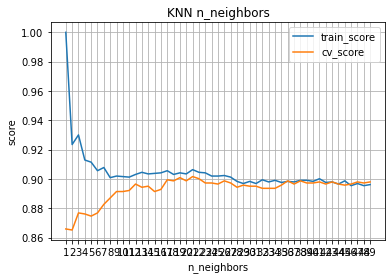

In [54]:
clf_knn = KNeighborsClassifier()
_range = np.arange(1, 50)
train_scores, test_scores = validation_curve(clf_knn, train_x, train_y, param_range=_range, cv=3, param_name='n_neighbors')

plt.figure()
plt.plot(_range, np.mean(train_scores, axis=1), label='train_score')
plt.plot(_range, np.mean(test_scores, axis=1), label='cv_score')
plt.title("KNN n_neighbors")
plt.xlabel("n_neighbors")
plt.ylabel("score")
plt.xticks(_range)
plt.legend()
plt.grid()

In [62]:
_range = np.arange(1, 50)
param_grid = {'n_neighbors': _range}
gridsearch_svm = GridSearchCV(clf_knn, param_grid=param_grid, cv=3, )
gridsearch_svm.fit(train_x, train_y)
print(gridsearch_svm.best_params_)
time_start = process_time()
clf_knn = KNeighborsClassifier(n_neighbors=gridsearch_svm.best_params_['n_neighbors'])
clf_knn = clf_knn.fit(train_x, train_y)
predict_y = clf_svm.predict(test_x)
time_end = process_time()
print(accuracy_score(test_y, predict_y))
print(time_end-time_start)

{'n_neighbors': 21}
0.9011627906976745
0.017890999999963242


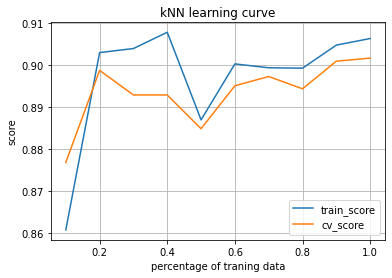

In [56]:
_range = np.linspace(0.1, 1.0, 10)
x, train_scores, test_scores = learning_curve(clf_knn, train_x, train_y, train_sizes=_range, cv=3)
plt.figure()
plt.plot(_range, np.mean(train_scores, axis=1), label='train_score')
plt.plot(_range, np.mean(test_scores, axis=1), label='cv_score')
plt.title("kNN learning curve")
plt.xlabel("percentage of traning data")
plt.ylabel("score")
plt.legend()
plt.grid()

### summary 
As general description, I set random_state=42（The Hitchhiker's Guide to the Galaxy）for reproducibility. I used preprocessing.scale to scale data, as perceptron is sensitive to scaling. This has actually improved accuracy performance. It might be better to use MinMaxScaler. I first tried to select some features based on biological meaning, but the results is not as good as using all features. Some further feature engineering (get volume from radius etc.) might help to further improve the performance.     

* Performance on time 
DT=0.0028959999999997876  
NN=1.2619889999999998  
AdaBoost=2.1961220000000026  
SVM=0.0434139999999843  
kNN=0.017890999999963242    

The training time various depend on hyper-parameters and data size. This data is less than 2000 samples, not big and with possible high variance and bias. Based on the values used in this experiment, SVM, DT, and kNN are relatively fast, while NN and boosting are slow. For DT, I applied pruning which reduces complexity hence saved time. kNN does not have model and the time complexity is O(nd), n is the total number of data-points in the training data and d is the total number of features in the dataset, so it is not optimal for large dataset. It does not generalize over data but scans the training data and calculate distance between query point and current point. As this data is bigger than breast cancer dataset, kNN run slower. Boosting is usually slow, as time depends on the runtime of weak learner used. But in this case, it is actually not too slow. SVM is usually fast, as it uses quadratic optimization. For NN, time cost is usually high as it takes backpropagation for gradient computation. It takes longer as compared to the breast cancer analyssi, possibly because I used bigger layer with 21 nodes. 

* Performance on accuracy  
DT=0.8808139534883721  
NN=0.9069767441860465  
AdaBoost=0.8808139534883721  
SVM=0.9011627906976745  
kNN=0.9011627906976745

For this small dataset, kNN and SVM performed well, DT and AdaBoost not so well; and overall accuracy lower than breast cancer data. I think it is the data nature: merging 2 datasets increased variance and biometrics data is of high noise. The gap between training and cv scores on learning curve is not big for most models, suggesting reasonable variance and bais in the data. So lower accuracy is likely due to the nature that those biometrics features are not good predictors for the disease.  

## Hackathon: Prediction of diabetes risk with Natural Language Processing and other medical record data mining 

To improve our understanding of diabetes and help people manage the disease, we developed a predictive model on diabetes on MIMIC III and PIMA medical data using NLP and other integrated machine leaning models. We explored features of glucose level, BMI (body mass index), age as well as free-text medical notes. We started with single classifier, improved by GridSearchCV and model ensemble, finally achieved an accuracy of 88%. We consider our model could potentially complement some existing preventive models for individuals to monitor their risk of diabetes and support medical diagnosis.   

### Introduction
[Type2 diabetes](https://en.wikipedia.org/wiki/Diabetes_mellitus_type_2), an aging related disease, is a long-term metabolic disorder that is characterized by high blood sugar, insulin resistance, and relative lack of insulin.  
There is an increase of the disease for the past decades and this increase is believed to be primarily due to the global population aging, a decrease in exercise, and increasing rates of obesity. The five countries with the greatest number of people with diabetes as of 2000 are India having 31.7 million, China 20.8 million, the United States 17.7 million, Indonesia 8.4 million, and Japan 6.8 million. It is recognized as a global epidemic by the World Health Organization.  
![img](img/global_t2d.png) 

### Why  
Diabetes is prevalent in the US with more than 450 million patients with various sever complications and is one of the major challenges in health care. A timely diagnosis and preventative treatment could reduce medical cost and increase life quality of patients. With advancement on portable medical devices, individuals can easily monitor their glucose level, body weight and fat ratio data continuously and easily. Further with a predictive model, they can detect abnormal condition before they go to hospital. 
  
### Material and Methods
#### Data
Two independent datasets were used in this study.  
[MIMIC III](https://physionet.org/content/mimiciii-demo/1.4/)  
[PIMA](https://en.wikipedia.org/wiki/RNA-Seq) Pima Indians Diabetes Database 

#### Methods
0. Setup environment  
`build.sbt` for scala/Spark, `environment.yml` for modeling with Python  
Python in `PEP8` coding style  
1. ETL
Identified case/control from MIMC and PIMA dataset with Spark   
To test phynotyping method and get output of case/control Member_ID, with sbt execute 
```
testOnly *T2dmPhenotypeTest
```  
2. EDA  
Basic statistics is provided, visualization of the dataset  
Execute `eda.ipynb` or `eda.py` for EDA and data cleaning, `eda_plot.R` to plot the following pictures  
MIMC  
![img](img/mimc.all.png)
PIMA  
![img](img/pima.all.png)
3. Model training 
Execute `ml_pipeline.ipynb` or `ml_pipeline.py` for model training     
a. Single baseline model   
b. Search best parameters with GridSearchCV  
c. Improve single model performance with best parameters  
d. Multiple models training, compare performance    
e. Model ensemble      
4. NLP data mining on soap free-text notes  
Unsuccessful attempt, see paper and `soap_notes_nlp.ipynb`   
![img](img/nlp_pipeline.png)   
 

### Results and Conclusion
In summary, our model achieved decent accuracy on type 2 diabetes prediction with numeric features including BMI, age and glucose level. Accuracy and AUC stays as 0.884 and 0.88, respectively. This provides a reliable model for general population to monitor their health using portable devices.  
![img](img/confusion_matrix.png)

### Tech stack
![img](img/tech_stack.png)

0.8688148639681487
accuracy 0.890


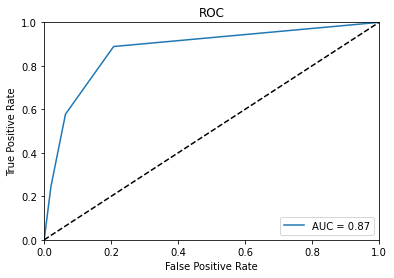

In [10]:

clf_knn = KNeighborsClassifier(metric = 'minkowski', n_neighbors=3)
clf_knn = clf_knn.fit(X_train, y_train)
print(cross_val_score(clf_knn, X_train, y_train, cv=5).mean())

predict_y = clf_knn.predict(test_x)
print("accuracy %0.3lf" % accuracy_score(test_y, predict_y))

probas_ = clf_knn.predict_proba(X_test)
y_test[y_test == 2] = 0
fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr)

# Plot roc curve
plt.clf()
plt.plot(fpr, tpr, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.savefig('../results/knn.roc.pdf')
plt.show()

For modeling with numeric features, full data is split into train and test, with a ratio of 80% vs 20%. We started with single KNN model with n_neighbors=3, as KNN is easy to interpret. This model achieved accuracy of 0.88 and AUC of 0.87

### pipeline
model ensemble with GridSearchCV

In [17]:
def GridSearchCV_run(pipeline, train_x, train_y, test_x, test_y, param_grid, score = 'accuracy'):
    result = {}
    gridsearch = GridSearchCV(estimator = pipeline, param_grid = param_grid, scoring = score)
    # gridsearch split train to train and test for cv
    search = gridsearch.fit(train_x, train_y) 
    print("GridSearchCV best score： %0.3lf" % search.best_score_)
    print("GridSearchCV best params：", search.best_params_)
    
    predict_y = gridsearch.predict(test_x)
    print("accuracy %0.3lf" % accuracy_score(test_y, predict_y))
    result['predict_y'] = predict_y
    result['accuracy_score'] = accuracy_score(test_y, predict_y)
    
    return result

In [18]:
def model_output(N):
    clf = [   
    RandomForestClassifier(random_state = 42, criterion = 'gini'),
    KNeighborsClassifier(metric = 'minkowski'),
    SVC(random_state = 42), ]

    clf_names = [ 
                'random_forest',
                'kneighbor',
                'svc',]

    clf_param = [
                {'random_forest__n_estimators':[N], 'random_forest__max_features':[N]} ,
                {'kneighbor__n_neighbors':np.arange(1, 30)},
                {'svc__C':10.0 ** np.arange(-2, 2), 'svc__gamma':10.0 ** np.arange(-5, 1)},]

    for model, model_name, model_param in zip(clf, clf_names, clf_param):
        pipeline = Pipeline([
                ('scaler', StandardScaler()),
                (model_name, model)
        ])
        result = GridSearchCV_run(pipeline, train_x, train_y, test_x, test_y, model_param , score = 'accuracy')


In [26]:
### pima+mimc data
N =3
model_output(N)

GridSearchCV best score： 0.868
GridSearchCV best params： {'random_forest__max_features': 3, 'random_forest__n_estimators': 3}
accuracy 0.884
GridSearchCV best score： 0.902
GridSearchCV best params： {'kneighbor__n_neighbors': 21}
accuracy 0.907
GridSearchCV best score： 0.897
GridSearchCV best params： {'svc__C': 1.0, 'svc__gamma': 0.1}
accuracy 0.904


In [82]:
### pima data alone
N=8
model_output(N)

GridSearchCV best score： 0.744
GridSearchCV best params： {'random_forest__max_features': 8, 'random_forest__n_estimators': 8}
accuracy 0.740
GridSearchCV best score： 0.756
GridSearchCV best params： {'kneighbor__n_neighbors': 25}
accuracy 0.740
GridSearchCV best score： 0.764
GridSearchCV best params： {'svc__C': 10.0, 'svc__gamma': 0.01}
accuracy 0.773


### single model improved with best param

0.8979636810877688
accuracy 0.904


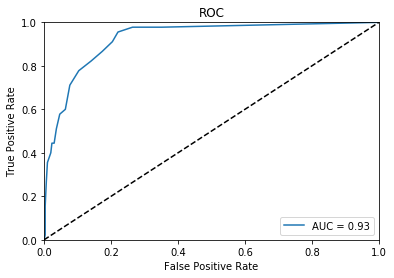

In [17]:
clf_knn = KNeighborsClassifier(metric = 'minkowski', n_neighbors=21)
clf_knn = clf_knn.fit(X_train, y_train)
print(cross_val_score(clf_knn, X_train, y_train, cv=5).mean())

predict_y = clf_knn.predict(test_x)
print("accuracy %0.3lf" % accuracy_score(test_y, predict_y))

probas_ = clf_knn.predict_proba(X_test)
y_test[y_test == 2] = 0
fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr)

# Plot roc curve
plt.clf()
plt.plot(fpr, tpr, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.savefig('../results/knn.grid.roc.pdf')
plt.show()

We then used GridSearchCV to automate best parameter searching. After GridSearchCV, we trained model with best parameters detected. The accuracy and AUC of KNN improved to 0.90 and 0.93, respectively

In [15]:
# train with best param

clf_svm = SVC(probability=True, C= 10.0, gamma=0.01,random_state = 42)
clf_svm = clf_svm.fit(X_train, y_train)

clf_rf = RandomForestClassifier(n_estimators=3, max_features=3,random_state = 42)
clf_rf = clf_rf.fit(X_train, y_train)

clf_knn = KNeighborsClassifier(metric = 'minkowski', n_neighbors=21)
clf_knn = clf_knn.fit(X_train, y_train)

### model ensembl

In [23]:
clf_vote = VotingClassifier(
    estimators=[
        ('svm', clf_svm),
        ('knn', clf_knn),
        ('RF', clf_rf),
        ],
    weights=[2,8,4],
    voting='soft')
clf_vote.fit(X_train,y_train)


VotingClassifier(estimators=[('svm',
                              SVC(C=10.0, cache_size=200, class_weight=None,
                                  coef0=0.0, decision_function_shape='ovr',
                                  degree=3, gamma=0.01, kernel='rbf',
                                  max_iter=-1, probability=True,
                                  random_state=42, shrinking=True, tol=0.001,
                                  verbose=False)),
                             ('knn',
                              KNeighborsClassifier(algorithm='auto',
                                                   leaf_size=30,
                                                   metric='minkowski',
                                                   metric_params=None,
                                                   n_jobs=None, n_n...
                                                     class_weight=None,
                                                     criterion='gini',
                   

In [51]:
print(cross_val_score(clf_vote, X_train, y_train, cv=5).mean())
print(cross_val_score(clf_vote, X_train, y_train, cv=5))
predict_y = clf_vote.predict(test_x)
print("accuracy %0.3lf" % accuracy_score(test_y, predict_y))

0.8782634980591185
[0.88727273 0.86545455 0.91272727 0.83941606 0.88644689]
accuracy 0.884


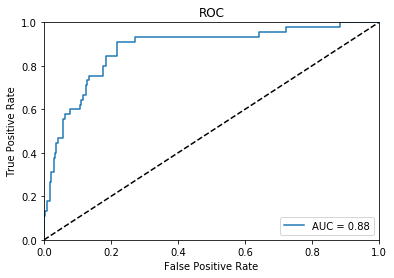

In [128]:
# Plot ROC curve
# Compute roc and auc
probas_ = clf_vote.predict_proba(X_test)
y_test[y_test == 2] = 0
fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr)

# Plot roc curve
plt.clf()
plt.plot(fpr, tpr, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.savefig('../results/vote.roc.pdf')
plt.show()

We then included additional model of SVM and Random Forest to compare different models. Random Forest is a bagging method, which reduces variance. As our dataset is merged of 2, resulting higher variance. SVM is selected because it is good for dataset of small size. Accuracy for RF and SVM are 0.88 and 0.90. KNN achieved the best performance.
Next, we applied model ensemble, which is optimal when classifiers are distinct, and our 3 individual models are very different. We used VotingClassifier function giving each model a weight. This time accuracy and AUC stays as 0.88 and 0.88. Model ensemble did not further improve performance. It is possible each individual model has already captured same variance thus ensemble them together is unable to further improve the model.

In [21]:
def plot_confusion_matrix(clf_vote, y_true, test_x, class_names):
    """
    plot confusion matrix
    """
    y_pred = clf_vote.predict(test_x)
    cf_matrix = confusion_matrix(y_true, y_pred)
    cf_matrix_normalized = cf_matrix.astype('float')/cf_matrix.sum(axis = 1)[:, np.newaxis]
    # fig, ax = plt.subplots(figsize=(5,4))
    plt.title('Normalized Confusion Matrix')
    annot_kws = {"va": 'center'}
    ax = sns.heatmap(cf_matrix_normalized, annot=True, fmt='.2%', cmap='Blues', annot_kws=annot_kws) 
    plt.xlabel('Predicted')
    plt.ylabel('True')
    ax.xaxis.set_ticklabels(class_names); ax.yaxis.set_ticklabels(class_names)
    plt.savefig('confusion_matrix.png')

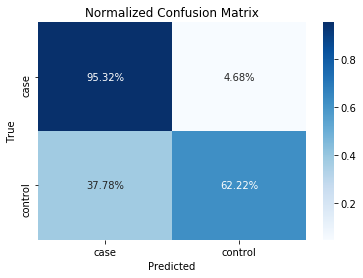

In [26]:
plot_confusion_matrix(clf_vote, test_y, test_x, class_names=['case','control'])

For NLP modeling with free-text soap notes, BERT was unable to finish training, multinomialNB generated very high accuracy score, likely due to strong indicators in note, which are missed in previous cleaning. This soap notes approach seems to be a dead end in this MIMC dataset.In summary, our model achieved decent accuracy on type 2 diabetes prediction with numeric features including BMI, age and glucose level. Confusion matrix also revealed the prediction results is useful. This provides a reliable model for general population to monitor their health using portable devices on simple features.

#### Discussion
With an ever growing aged and obese population, diabetes has become one of the leading causes of mortality in the US and worldwide. Early detection and prevention of the disease is key to management and treatment, which helps to reduce burden of health care system. Using data from two independent datasets, we developed a diabetes prediction model that takes numeric values which can be easily collected by individual at home so as to inform people for potential risk.
We have explored 2 datasets of MIMC and PIMA and found some features suitable for the disease prediction. Using such data, we have developed a usable ensemble model on BMI, age and glucose level to predict type 2 diabetes risk. Those numeric features can be easily collected by individuals at home with portable devices.  
Major challenges are on getting suitable data and understanding data. We started with attempts to predict type 2 diabetes related disorders such as diabetic ketoacidosis and sever hypoglycemia as there as not many studies, but there are not enough data (ICD9 code). So, we moved to predict diabetes. After data cleaning, we learned there are not enough data with glucose level to use the MIMC dataset, so we implemented another PIMA dataset. We took great effort to read research papers and investigated Kaggle datasets and finally found this PIMA dataset. Initially, we planned to use soap free-text notes as part of the NLP analysis, but the soap notes are too short and with key words not suitable for training purpose.  
Another challenge come from NLP model. The NLP training with BERT did not go well: we used Ggoogle colab GPU with BERT, but the training is unable to finish; possibly because the SOAP string is too short and medical term make it very sparse.  
 Diverse model ensemble with diverse models barely improved accuracy, perhaps because different models all picked same strong predictors hence adding different model together did not improve performance. There are also studies using deep learning and achieve higher accuracy, although we are concerned that the data size is too small for deep learning methods, we plan to try deep learning later to further optimize our model. A Deep learning (DL) network is a method that uses artificial neural network (ANN) in which neurons are interconnected to each other with hidden layer architects. Deep learning has various applications and advantages in NLP as the algorithm try to learn high-level features in an incremental manner.  
In addition, it will be helpful to find another dataset as independent validation of our model to confirm robustness.  